# The Metropolitan Museum of Art: Open Access

### Kate Stadelman
### Tools One Final Project, Winter 2022

## Introduction

dsfds

## Open Access Dataset

Stuff here

In [31]:
from ast import Assert
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import requests
import seaborn as sns

%matplotlib inline

In [2]:
# enforce a specific commit (cc6310135aeafd01fb03588929fb9d00c5cbc606) from Jan 17, 2022 
# because data is manually input with no tagged releases
sources = {
    'license': {
        'url': 'https://raw.githubusercontent.com/metmuseum/openaccess/cc6310135aeafd01fb03588929fb9d00c5cbc606/',
        'file': 'LICENSE'
    },
    'readme': { 
        'url': 'https://raw.githubusercontent.com/metmuseum/openaccess/cc6310135aeafd01fb03588929fb9d00c5cbc606/', 
        'file': 'README.md' 
    }, 
    'data': { 
        'url': 'https://media.githubusercontent.com/media/metmuseum/openaccess/cc6310135aeafd01fb03588929fb9d00c5cbc606/', 
        'file': 'MetObjects.csv',
        'checksum': '68d26f76485ccd066d45b6044d0954f1508e431a21c4ef7133f45c46931d4773' 
    }
}

In [3]:
# define where you want the data to live and mkdir if necessary
data_path = os.path.join(os.getcwd(), 'data', '')
if not os.path.exists(data_path):
    os.mkdir(data_path)

In [4]:
def get_data(source, outpath):
    # get data and output to file
    try:
        r = requests.get(source['url'] + source['file'])
        r.raise_for_status()
        r.encoding = 'UTF-8'
        with open(outpath + source['file'], 'w') as f:
            f.write(r.text)
    except requests.exceptions.RequestException as e:
        print('Requests Error:', e)

    # validate data file
    if 'checksum' in source:
        try:
            with open(outpath + source['file'],"rb") as f:
                bytes = f.read()                                        # read entire file in as bytes
                readable_hash = hashlib.sha256(bytes).hexdigest()
            assert source['checksum'] == readable_hash                  # compare SHA256 hash
        except AssertionError:
            print('SHA256 Error:', source['checksum'], readable_hash)  

# download data
for source in sources:
    get_data(source=sources[source], outpath=data_path)

In [12]:
# load dirty data to dataframe
df = pd.read_csv(data_path + sources['data']['file'], sep=',', index_col=4, low_memory=False)

In [14]:
df.head(10)

,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Gallery Number,Department,AccessionYear,Object Name,Title,Culture,...,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
Object ID,,,,,,,,,,,,,,,,,,,,,
1,1979.486.1,False,False,False,NaN,The American Wing,1979,Coin,One-dollar Liberty Head Coin,NaN,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/1,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
2,1980.264.5,False,False,False,NaN,The American Wing,1980,Coin,Ten-dollar Liberty Head Coin,NaN,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/2,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
3,67.265.9,False,False,False,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,NaN,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/3,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
4,67.265.10,False,False,False,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,NaN,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/4,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
5,67.265.11,False,False,False,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,NaN,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/5,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
6,67.265.12,False,False,False,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,NaN,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/6,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
7,67.265.13,False,False,False,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,NaN,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/7,NaN,NaN,"Metropolitan Museum of Art, New York, NY",Birds|Coins,http://vocab.getty.edu/page/aat/300266506|http...,https://www.wikidata.org/wiki/Q5113|https://ww...
8,67.265.14,False,False,False,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,NaN,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/8,NaN,NaN,"Metropolitan Museum of Art, New York, NY",Eagles|Men|Profiles,http://vocab.getty.edu/page/aat/300250049|http...,https://www.wikidata.org/wiki/Q2092297|https:/...
9,67.265.15,False,False,False,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,NaN,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/9,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN


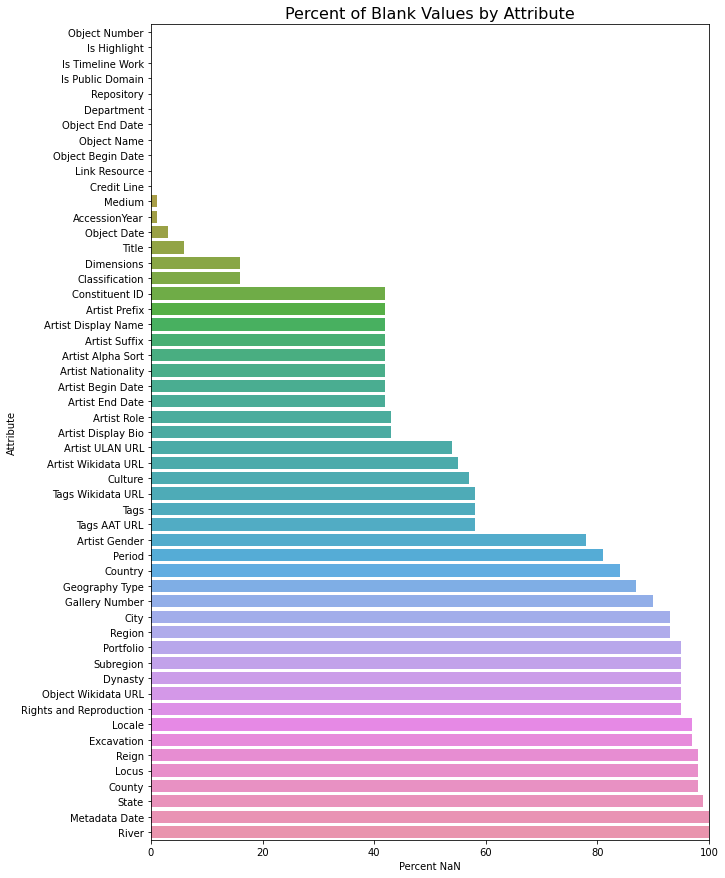

In [68]:
nans_df = pd.DataFrame(df.isna().mean().mul(100).round(), columns=['Percent NaN'])
nans_df = nans_df.rename_axis('Attribute').reset_index()
nans_df.sort_values(by=['Percent NaN'], inplace=True)

fig = plt.figure(figsize=(10,15))
ax = sns.barplot(x='Percent NaN', y='Attribute', data=nans_df)
ax.set_xlim(0,100)
plt.title('Percent of Blank Values by Attribute', fontsize=16)
plt.show()

No good region data, but can use Department as a proxy. Too many entries for artist and credit line to be useful.

In [288]:
# too many artists to use as a categorical variable
print('Number of Unique Artists:', df['Artist Display Name'].nunique())
print('Number of Unique Artists with Highlight Works:', df['Artist Display Name'][df['Is Highlight'] == True].nunique())

# too many credit lines to use as a categorical variable
print('Number of Unique Credit Lines:', df['Credit Line'].nunique())
print('Number of Unique Credit Lines with Highlight Works:', df['Credit Line'][df['Is Highlight'] == True].nunique())

Number of Unique Artists: 64330
Number of Unique Artists with Highlight Works: 1328
Number of Unique Credit Lines: 35247
Number of Unique Credit Lines with Highlight Works: 1421


Talk about measures

In [365]:
# begin our dataframe with 'best' data
met_df = df[['Department','Is Highlight','Is Timeline Work']].copy()                              # Department, Is Highlight, & Is Timeline Work look good
met_df['Is Displayed'] = df['Gallery Number'].apply(lambda x: False if x == np.nan else False)    # consider art displayed if it has a gallery number
print(met_df.shape)

(477202, 4)


In [366]:
# accession year
met_df['Accession Year'] = df['AccessionYear'].apply(lambda x: str(x)[0:4] if isinstance(x, str) else x)      # accession year is sometimes YYYY-MM-DD
met_df['Credit Line'] = df['Credit Line']
met_df['Credit Line Year'] = met_df['Credit Line'].str.extract(r'(\d{4})', expand = True)          # credit line sometimes has embedded accession year
met_df['Accession Year'].fillna(met_df['Credit Line Year'], inplace=True)
met_df.drop(columns=['Credit Line','Credit Line Year'], inplace=True)
met_df.dropna(inplace=True)
met_df['Accession Year'] = met_df['Accession Year'].astype(int)
print(met_df.shape)

(474280, 5)


In [367]:
# object year
df['Object Begin Date'] = df['Object Begin Date'].astype(int)
df['Object End Date'] = df['Object End Date'].astype(int)

met_df['Object Year'] = df['Object Begin Date']                                       # after close review, begin year more closely reflects object date col
met_df = met_df.loc[(df['Object Begin Date']!=0) & (df['Object End Date']!=0) & (df['Object Begin Date']<=df['Object End Date'])]         
met_df['Object Year'] = met_df['Object Year'].astype(int)
print(met_df.shape)

(472901, 6)


In [368]:
# classifications
print('Percent of Blank Classifications:', round((df['Classification'].isnull().sum()/df.shape[0])*100,2))
print('Number of Unique Classifications:', df['Classification'].nunique())

met_df = met_df.loc[~df['Classification'].isna()]

Percent of Blank Classifications: 16.38
Number of Unique Classifications: 1205


In [369]:
# too many credit lines to use as a categorical variable
classifications = [ 'Print', 'Textile', 'Photograph', 'Drawing', 'Vase', 'Book', 'Ceramic', 'Metal', 'Painting', 'Glass', 'Negative', 'Sculpture', 'Sword',
                   'Stone', 'Wood', 'Jewelry']

met_df['Classification'] = df['Classification'].apply(lambda x: [ i for i in classifications if i in str(x) ])
met_df['Classification'] = met_df['Classification'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

In [370]:
print('Percent of Non-Blank Classifications Belonging to Top', len(classifications), 'Classifications',
      round((met_df['Classification'].value_counts().sum()/met_df.shape[0])*100,2))

Percent of Non-Blank Classifications Belonging to Top 16 Classifications 87.38


In [371]:
met_df.dropna(inplace=True)

In [372]:
met_df

,Department,Is Highlight,Is Timeline Work,Is Displayed,Accession Year,Object Year,Classification
Object ID,,,,,,,
5209,European Sculpture and Decorative Arts,False,False,False,1910,1700,Metal
5210,European Sculpture and Decorative Arts,False,False,False,1910,1700,Metal
7829,European Sculpture and Decorative Arts,False,False,False,1906,1700,Metal
9367,Modern and Contemporary Art,False,False,False,1976,1894,Ceramic
21466,European Sculpture and Decorative Arts,False,False,False,2014,1730,Textile
...,...,...,...,...,...,...,...
857142,Drawings and Prints,False,False,False,1970,1890,Book
857146,Drawings and Prints,False,False,False,1970,1868,Book
857171,Drawings and Prints,False,False,False,1970,1867,Book


In [373]:
met_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345844 entries, 5209 to 857173
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Department        345844 non-null  object
 1   Is Highlight      345844 non-null  bool  
 2   Is Timeline Work  345844 non-null  bool  
 3   Is Displayed      345844 non-null  bool  
 4   Accession Year    345844 non-null  int64 
 5   Object Year       345844 non-null  int64 
 6   Classification    345844 non-null  object
dtypes: bool(3), int64(2), object(2)
memory usage: 14.2+ MB
